In [170]:
#Basic 
import numpy as np 
import pandas as pd
import collections

#Plotting 
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [171]:
#Regular modeling
import folium
import squarify
import matplotlib
import statsmodels.api as sm
from itertools import groupby
from operator import itemgetter
from math import sqrt

#Extended modeling
import matplotlib
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
from matplotlib.collections import PolyCollection

from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn import metrics, mixture, cluster, datasets
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA,SparsePCA,KernelPCA,NMF

from mlxtend.preprocessing import minmax_scaling

import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

## Data

### election data

In [179]:
df_president = pd.read_csv('/Users/rosaria/Desktop/data/archive/president_county_candidate.csv')
df_president.head()
df_president.shape

(31668, 6)

In [173]:
df_predsident_REP = df_president.query('party == "REP"')
df_predsident_DEM = df_president.query('party == "DEM"')

In [174]:
df_predsident_REP = pd.DataFrame(df_predsident_REP.groupby(['state', 'county'])['total_votes'].sum())
df_predsident_REP = df_predsident_REP.rename(columns={'total_votes':'votes REP predsident'})

df_predsident_DEM = pd.DataFrame(df_predsident_DEM.groupby(['state', 'county'])['total_votes'].sum())
df_predsident_DEM = df_predsident_DEM.rename(columns={'total_votes':'votes DEM predsident'})

In [175]:
df_president_votes = pd.concat([df_predsident_REP,df_predsident_DEM], axis=1)

In [176]:
df_president_votes

votes REP predsident  votes DEM predsident
state   county                                                       
Alabama Autauga County                    19838                  7503
        Baldwin County                    83544                 24578
        Barbour County                     5622                  4816
        Bibb County                        7525                  1986
        Blount County                     24711                  2640
...                                         ...                   ...
Wyoming Sweetwater County                 12229                  3823
        Teton County                       4341                  9848
        Uinta County                       7496                  1591
        Washakie County                    3245                   651
        Weston County                      3107                   360

[4633 rows x 2 columns]

### census data

In [178]:
df_census = pd.read_csv('/Users/rosaria/Desktop/data/archive (1)/acs2017_county_data.csv')
df_census = df_census.rename(columns={'State':'state', 'County':'county'})
df_census.shape

(3220, 37)

In [15]:
df_census = df_census.drop(['CountyId'], axis=1)

In [16]:
vars_to_merge = [x for x in df_census.columns if x not in ['state', 'county']]
df_census = df_census.groupby(['state', 'county'])[vars_to_merge].sum()

In [17]:
df = pd.concat([df_president_votes, df_census], axis=1)
df = df.fillna(0)

In [19]:
df_census

TotalPop    Men   Women  Hispanic  White  Black  \
state   county                                                               
Alabama Autauga County        55036  26899   28137       2.7   75.4   18.9   
        Baldwin County       203360  99527  103833       4.4   83.1    9.5   
        Barbour County        26201  13976   12225       4.2   45.7   47.8   
        Bibb County           22580  12251   10329       2.4   74.6   22.0   
        Blount County         57667  28490   29177       9.0   87.4    1.5   
...                             ...    ...     ...       ...    ...    ...   
Wyoming Sweetwater County     44527  22981   21546      16.0   79.6    0.8   
        Teton County          22923  12169   10754      15.0   81.5    0.5   
        Uinta County          20758  10593   10165       9.1   87.7    0.1   
        Washakie County        8253   4118    4135      14.2   82.2    0.3   
        Weston County          7117   3756    3361       1.4   91.6    0.5   

                           Native  Asian  Pacific  VotingAgeCitizen  ...  \
state   county                                                       ...   
Alabama Autauga County        0.3    0.9      0.0             41016  ...   
        Baldwin County        0.8    0.7      0.0            155376  ...   
        Barbour County        0.2    0.6      0.0             20269  ...   
        Bibb County           0.4    0.0      0.0             17662  ...   
        Blount County         0.3    0.1      0.0             42513  ...   
...                           ...    ...      ...               ...  ...   
Wyoming Sweetwater County     0.6    0.6      0.5             31025  ...   
        Teton County          0.3    2.2      0.0             16692  ...   
        Uinta County          0.9    0.1      0.0             14235  ...   
        Washakie County       0.4    0.1      0.0              6125  ...   
        Weston County         0.1    4.3      0.0              5510  ...   

                           Walk  OtherTransp  WorkAtHome  MeanCommute  \
state   county                                                          
Alabama Autauga County      0.6          1.3         2.5         25.8   
        Baldwin County      0.8          1.1         5.6         27.0   
        Barbour County      2.2          1.7         1.3         23.4   
        Bibb County         0.3          1.7         1.5         30.0   
        Blount County       0.4          0.4         2.1         35.0   
...                         ...          ...         ...          ...   
Wyoming Sweetwater County   2.8          1.3         1.5         20.5   
        Teton County       11.7          3.8         5.7         14.3   
        Uinta County        1.1          1.3         2.0         19.9   
        Washakie County     6.9          1.3         4.4         14.3   
        Weston County       3.0          1.6         6.9         25.7   

                           Employed  PrivateWork  PublicWork  SelfEmployed  \
state   county                                                               
Alabama Autauga County        24112         74.1        20.2           5.6   
        Baldwin County        89527         80.7        12.9           6.3   
        Barbour County         8878         74.1        19.1           6.5   
        Bibb County            8171         76.0        17.4           6.3   
        Blount County         21380         83.9        11.9           4.0   
...                             ...          ...         ...           ...   
Wyoming Sweetwater County     22739         78.4        17.8           3.8   
        Teton County          14492         82.1        11.4           6.5   
        Uinta County           9528         71.5        21.5           6.6   
        Washakie County        3833         69.8        22.0           8.1   
        Weston County          3407         68.2        21.9           8.8   

                           FamilyWork  Unemployment  
stat

In [20]:
df['votes REP president perc'] = df[df.columns[0]]/(df[df.columns[0]] + df[df.columns[1]])
df['votes DEM president perc'] = df[df.columns[1]]/(df[df.columns[0]] + df[df.columns[1]])

In [21]:
df[df['votes REP president perc'].isna() == True]

votes REP predsident  \
state   county                                             
Alaska  Aleutians East Borough                       0.0   
        Aleutians West Census Area                   0.0   
        Anchorage Municipality                       0.0   
        Bethel Census Area                           0.0   
        Bristol Bay Borough                          0.0   
...                                                  ...   
Vermont Orleans County                               0.0   
        Rutland County                               0.0   
        Washington County                            0.0   
        Windham County                               0.0   
        Windsor County                               0.0   

                                    votes DEM predsident  TotalPop       Men  \
state   county                                                                 
Alaska  Aleutians East Borough                       0.0    3338.0    2049.0   
        Aleutians West Census Area                   0.0    5784.0    3539.0   
        Anchorage Municipality                       0.0  298225.0  152311.0   
        Bethel Census Area                           0.0   17957.0    9435.0   
        Bristol Bay Borough                          0.0     917.0     532.0   
...                                                  ...       ...       ...   
Vermont Orleans County                               0.0   26951.0   13534.0   
        Rutland County                               0.0   59676.0   29275.0   
        Washington County                            0.0   58691.0   28997.0   
        Windham County                               0.0   43332.0   21172.0   
        Windsor County                               0.0   55485.0   27171.0   

                                       Women  Hispanic  White  Black  Native  \
state   county                                                                 
Alaska  Aleutians East Borough        1289.0       9.7   15.5    4.8    37.4   
        Aleutians West Census Area    2245.0      13.5   24.8    5.0    11.5   
        Anchorage Municipality      145914.0       8.9   59.2    5.2     6.8   
        Bethel Census Area            8522.0       2.2   10.2    0.7    82.0   
        Bristol Bay Borough            385.0       4.5   50.3    0.4    34.4   
...                                      ...       ...    ...    ...     ...   
Vermont Orleans County               13417.0       1.4   95.5    0.4     0.5   
        Rutland County               30401.0       1.4   95.5    0.7     0.3   
        Washington County            29694.0       1.9   94.4    0.8     0.3   
        Windham County               22160.0       2.2   93.5    0.8     0.1   
        Windsor County               28314.0       1.5   95.0    0.7     0.2   

                                    Asian  ...  WorkAtHome  MeanCommute  \
state   county                             ...                            
Alaska  Aleutians East Borough       26.1  ...         5.3          5.1   
        Aleutians West Census Area   37.7  ...         0.7          7.8   
        Anchorage Municipality        9.2  ...         3.8         18.9   
        Bethel Census Area            0.9  ...         4.1          7.4   
        Bristol Bay Borough           1.4  ...         3.1          9.4   
...                                   ...  ...         ...          ...   
Vermont Orleans County                0.3  ...         7.9         24.2   
        Rutland County                1.1  ...         5.2         21.1   
        Washington County             0.6  ...         7.2         22.9   
        Windham County                1.0  ...        12.1         21.3   
        Windsor County                0.8  ...         5.3         22.8   

                                    Employed  PrivateWork  PublicWork  \
state   county                                                          
Alaska  Aleutians East Borough        2405.0       

## EDA

In [22]:
df_final = minmax_scaling(df, columns = df.columns)

In [23]:
df_final.head(5)

votes REP predsident  votes DEM predsident  TotalPop  \
state   county                                                                 
Alabama Autauga County              0.017336              0.002480  0.005446   
        Baldwin County              0.073008              0.008123  0.020123   
        Barbour County              0.004913              0.001592  0.002593   
        Bibb County                 0.006576              0.000656  0.002234   
        Blount County               0.021595              0.000872  0.005706   

                             Men     Women  Hispanic  White     Black  \
state   county                                                          
Alabama Autauga County  0.005402  0.005489     0.027  0.754  0.217491   
        Baldwin County  0.019987  0.020256     0.044  0.831  0.109321   
        Barbour County  0.002807  0.002385     0.042  0.457  0.550058   
        Bibb County     0.002460  0.002015     0.024  0.746  0.253165   
        Blount County   0.005721  0.005692     0.090  0.874  0.017261   

                          Native     Asian  ...  WorkAtHome  MeanCommute  \
state   county                              ...                            
Alabama Autauga County  0.003322  0.021531  ...    0.075758     0.572062   
        Baldwin County  0.008859  0.016746  ...    0.169697     0.598670   
        Barbour County  0.002215  0.014354  ...    0.039394     0.518847   
        Bibb County     0.004430  0.000000  ...    0.045455     0.665188   
        Blount County   0.003322  0.002392  ...    0.063636     0.776053   

                        Employed  PrivateWork  PublicWork  SelfEmployed  \
state   county                                                            
Alabama Autauga County  0.005017     0.834459    0.311728      0.147368   
        Baldwin County  0.018629     0.908784    0.199074      0.165789   
        Barbour County  0.001847     0.834459    0.294753      0.171053   
        Bibb County     0.001700     0.855856    0.268519      0.165789   
        Blount County   0.004449     0.944820    0.183642      0.105263   

                        FamilyWork  Unemployment  votes REP president perc  \
state   county                                                               
Alabama Autauga County      0.0125      0.127139                  0.725577   
        Baldwin County      0.0125      0.134474                  0.772683   
        Barbour County      0.0375      0.303178                  0.538609   
        Bibb County         0.0375      0.200489                  0.791189   
        Blount County       0.0125      0.119804                  0.903477   

                        votes DEM president perc  
state   county                                    
Alabama Autauga County                  0.274423  
        Baldwin County                  0.227317  
        Barbour County                  0.461391  
        Bibb County                     0.208811  
        Blount County                   0.096523  

[5 rows x 38 columns]

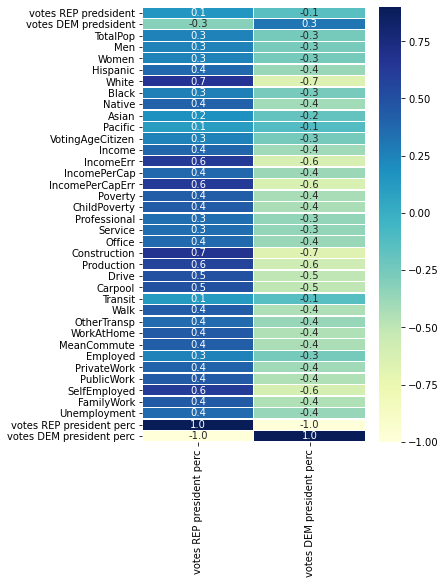

In [24]:
SpearmanCorr = df_final.corr(method='spearman')
x = SpearmanCorr[df.columns[-2:]]
plt.figure(figsize=(5,8))
sns.heatmap(x, vmax=.9, annot = True, cmap='YlGnBu', linewidths=.3, fmt='.1f')

In [25]:
df_state = df.reset_index().groupby('state').sum()
df_state = df_state.drop(df_state.columns[-2:], axis=1)

In [26]:
df_state['votes REP president perc'] = df_state[df_state.columns[0]]/(df_state[df_state.columns[0]] + df_state[df_state.columns[1]])
df_state['votes DEM president perc'] = df_state[df_state.columns[1]]/(df_state[df_state.columns[0]] + df_state[df_state.columns[1]])

In [27]:
df_state_sorted = df_state.sort_values('votes REP president perc')

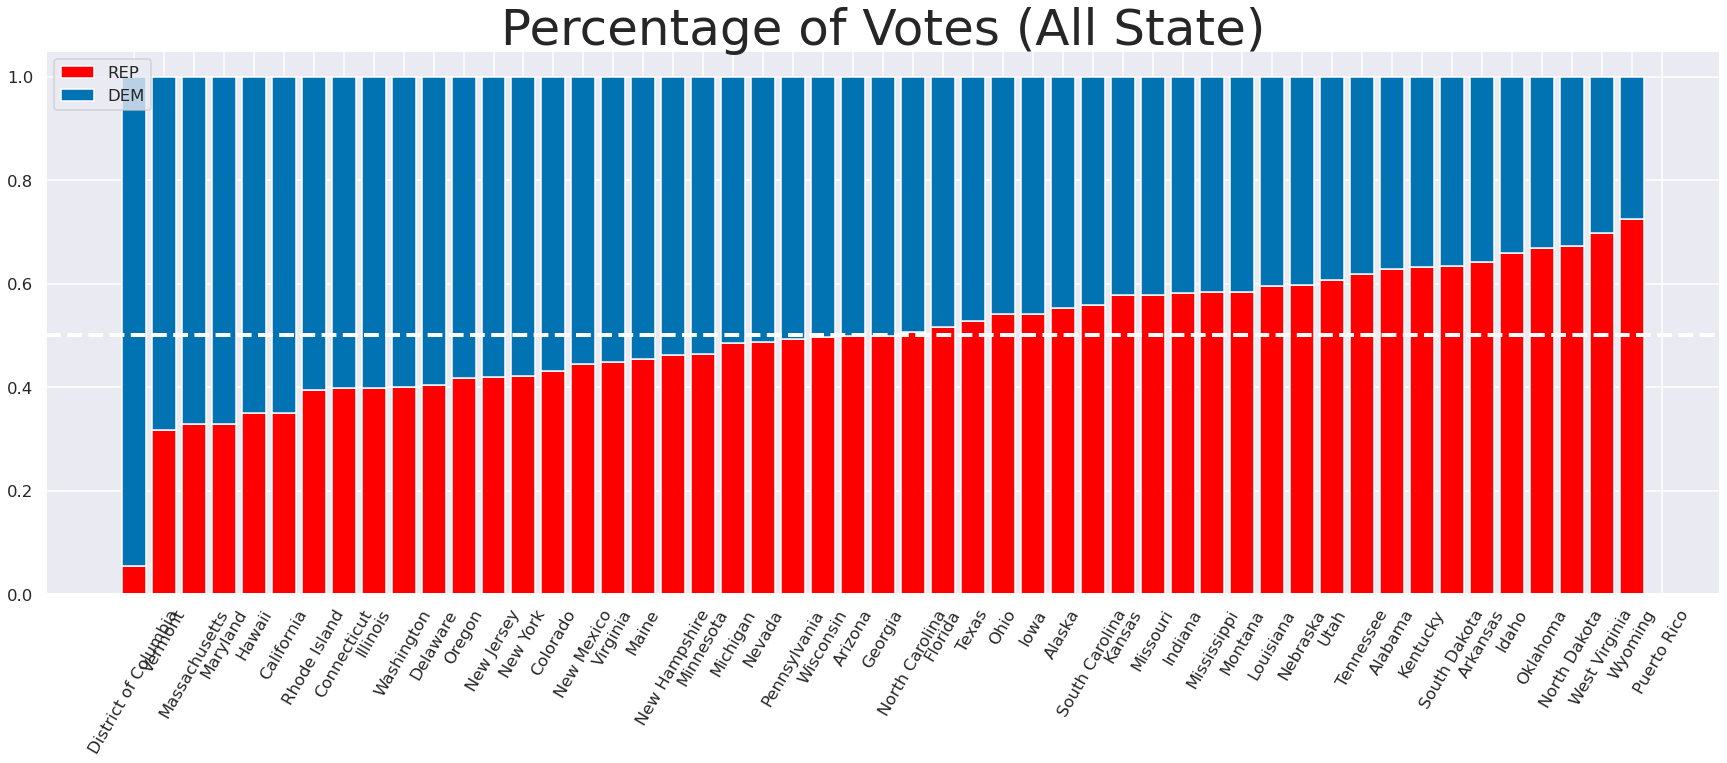

In [193]:
fig, ax = plt.subplots(figsize=(30,10))
x = np.arange(len(df_state_sorted.index))
width = 0.35
ax.bar(x, df_state_sorted['votes REP president perc'], color='red', label='REP')
ax.bar(x, df_state_sorted['votes DEM president perc'], bottom=df_state_sorted['votes REP president perc'], label='DEM')
ax.set_xticks(x)
ax.set_xticklabels(df_state_sorted.index)
ax.legend()
plt.title('Percentage of Votes (All State)', size=50)
plt.xticks(rotation=60)
plt.axhline(y=0.5, color='w', linestyle='--', linewidth=4)
plt.show()

In [29]:
swing_state = ['Florida', 'Pennsylvania','Michigan', 'Wisconsin', 'North Carolina', 'Arizona']
df_state_swing = df_state_sorted.loc[swing_state]

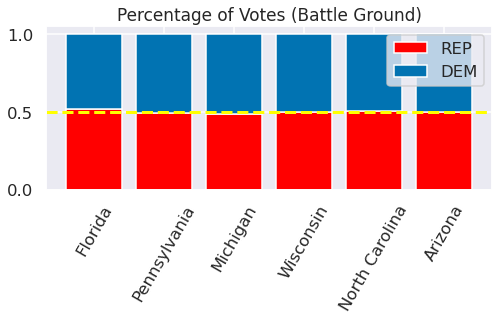

In [192]:
fig, ax = plt.subplots(figsize=(8,3))
x = np.arange(len(df_state_swing.index))
width = 0.35
ax.bar(x, df_state_swing['votes REP president perc'], color='red', label='REP')
ax.bar(x, df_state_swing['votes DEM president perc'], bottom=df_state_swing['votes REP president perc'], label='DEM')
ax.set_xticks(x)
ax.set_xticklabels(df_state_swing.index)
ax.legend()
plt.title('Percentage of Votes (Battle Ground)', size=17)
plt.xticks(rotation=60)
plt.axhline(y=0.5, color='yellow', linestyle='--', linewidth=3)
plt.show()

### 흐름
- 미국 대선 결과, 현재 트럼프 부정선거 주장, 
    - 미시간 주에서 우편 투표로 1만여표
    - 가짜 운전면허
    - 트럼프 표 쓰레기통으로
    - 하지만 주 언론은 코로나로 인해 우편투표가 확장된 결과, 히스패닉 등 소수층의 투표가 많아진 결과에 대비해 말한 것이라고 결론 지음
- 인구조사 데이터를 더 써서 그렇다면 주 선거의 결론이 지어지는 경합주를 정확하게 예측하면 어떨까?
    - train: 경합주를 제외한 나머지 주
    - test: 경합주 

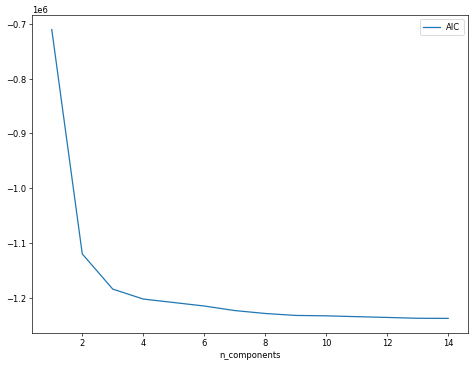

In [32]:
votes = [x for x in df.columns if x not in df_census]
factors = [x for x in df.columns if x not in votes]
X = df_final[factors].values

GM_n_components = np.arange(1, 15)
GM_models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in GM_n_components]

plt.figure(num=None, figsize=(8, 6), dpi=60, facecolor='w', edgecolor='r')
plt.plot(GM_n_components, [m.aic(X) for m in GM_models], label='AIC')
plt.tight_layout()
plt.legend(loc='best')
plt.xlabel('n_components');


In [33]:
df_final = df_final.dropna()

In [34]:
GM_n_classes = 2

GMcluster = mixture.GaussianMixture(n_components=GM_n_classes, covariance_type='full',random_state = 0)
GMcluster_fit = GMcluster.fit(df_final)
GMlabels = GMcluster_fit.predict(df_final)

print('Number of clusters: ' + format(len(np.unique(GMlabels))))

Number of clusters: 2


In [35]:
unique, counts = np.unique(GMlabels, return_counts=True)
dict(zip(unique, counts))

{0: 1581, 1: 3043}

In [36]:
df_final['Party_Cluster'] = GMlabels

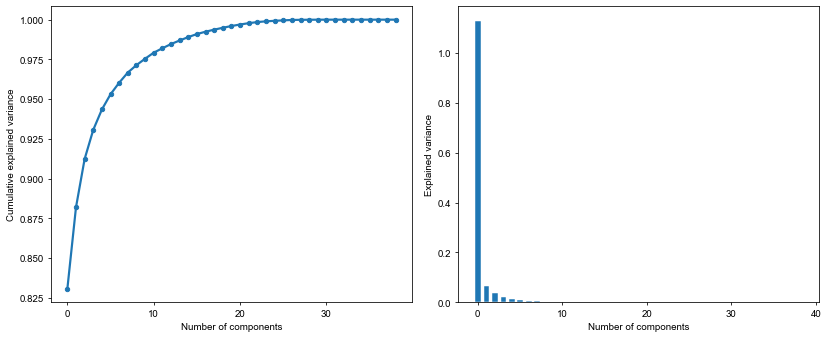

In [37]:
pca = PCA().fit(df_final)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=70, facecolor='w', edgecolor='k')
ax0, ax1 = axes.flatten()

sns.set('talk', palette='colorblind')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

ax0.plot(np.cumsum(pca.explained_variance_ratio_), marker='.')
ax0.set_xlabel('Number of components')
ax0.set_ylabel('Cumulative explained variance');

ax1.bar(range(df_final.shape[1]),pca.explained_variance_)
ax1.set_xlabel('Number of components')
ax1.set_ylabel('Explained variance');

plt.tight_layout()
plt.show()

In [38]:
n_PCA_90 = np.size(np.cumsum(pca.explained_variance_ratio_)>0.9) - np.count_nonzero(np.cumsum(pca.explained_variance_ratio_)>0.9)
print("Already: " + format(n_PCA_90) + " components cover 90% of variance.")

Already: 2 components cover 90% of variance.


<ipython-input-39-7de2869850fa>:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


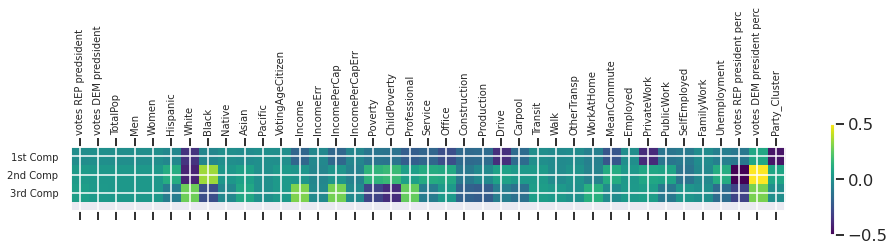

In [39]:
pca = PCA(3).fit(df_final)

X_pca=pca.transform(df_final) 

plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0,1,2,3],['1st Comp','2nd Comp','3rd Comp'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(df_final.columns)),df_final.columns,fontsize=10,rotation=90)
plt.tight_layout()
plt.show()

In [40]:
PCA_vars = [0]*len(df_final.columns)

def ExtractColumn(lst,j): 
    return [item[j] for item in lst] 

for i, feature in zip(range(len(df_final.columns)),df_final.columns):
    x = ExtractColumn(pca.components_,i)
    if ((max(x) > 0.2) | (min(x) < -0.2)):
        if abs(max(x)) > abs(min(x)):
            PCA_vars[i] = max(x)
        else:
            PCA_vars[i] = min(x)                 
    else:
        PCA_vars[i] = 0

PCA_vars = pd.DataFrame(list(zip(df_final.columns,PCA_vars)),columns=('Name','Max absolute contribution'),index=range(1,40,1))      
PCA_vars = (PCA_vars[(PCA_vars['Max absolute contribution']!=0)]).sort_values(by='Max absolute contribution',ascending=False)
PCA_vars

,Name,Max absolute contribution
38,votes DEM president perc,0.502999
8,Black,0.356839
13,Income,0.309702
15,IncomePerCap,0.292957
19,Professional,0.264797
23,Production,-0.207113
30,MeanCommute,-0.233917
21,Office,-0.261379
17,Poverty,-0.294694
24,Drive,-0.367189


In [41]:
df_null = df[df.isnull().any(axis=1)]
Null_county = np.array(df_null.index.get_level_values('county'))
df_final_estimation = df_final.drop(Null_county, level='county')

In [42]:
Response = pd.DataFrame({'Response':df_final_estimation['votes REP president perc']})

In [44]:
df_final_estimation_c = df_final_estimation.drop(votes, axis=1)

In [98]:
steady_state = [x for x in list(df_final_estimation.index.levels[0]) if x not in swing_state]

In [102]:
x_train = df_final_estimation_c.loc[(steady_state, )]
x_test = df_final_estimation_c.loc[(swing_state, )] # 경합주
y_train = Response.loc[(steady_state, )] 
y_test = Response.loc[(swing_state, )] # 경합주 
# print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

In [103]:
space={ 'max_depth': hp.quniform("max_depth", 2,25,1),
        'alpha': hp.uniform ('alpha', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 25, 1),
        'learning_rate' : hp.uniform('learning_rate', 0.00001, 0.8),
        'n_estimators': 500,
        'seed': 0}

def f_rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

def objective(space):
    clf = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), alpha = space['alpha'],
                        learning_rate = space['learning_rate'],min_child_weight=space['min_child_weight'],colsample_bytree=space['colsample_bytree'])

    evaluation = [( x_train, y_train), ( x_test, y_test)]
    
    clf_fit = clf.fit(x_train, y_train,verbose=False,eval_set=evaluation,early_stopping_rounds=20)
    
    pred = clf_fit.predict(x_test)
    score = f_rmse(y_test['Response'].values, pred)
    print(format(score))
    return {'loss': score, 'status': STATUS_OK } #loss=RMSE

trials = Trials()

best_hyperparams = fmin(fn = objective,space = space,algo = tpe.suggest,max_evals = 100,trials = trials)

0.0938818798858188                                     
0.07460036617636658                                                              
0.07723875341115141                                                               
0.09558173065454599                                                               
0.08679832072818214                                                               
0.09727030131020213                                                               
0.08186787558189156                                                               
0.07617587551831378                                                               
0.08902622198649292                                                               
0.08446028911554183                                                               
0.07802041792641681                                                                
0.09243833240873227                                                                
0.08094650805976383           

In [122]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'alpha': 0.07485908835615102, 'colsample_bytree': 0.833496372369444, 'learning_rate': 0.051069164120280626, 'max_depth': 21.0, 'min_child_weight': 11.0}


In [123]:
Model_XGB = xgb.XGBRegressor(objective='reg:squarederror', 
                             colsample_bytree=best_hyperparams.get('colsample_bytree'), 
                             learning_rate=best_hyperparams.get('learning_rate'),
                             max_depth=int(best_hyperparams.get('max_depth')), 
                             alpha=best_hyperparams.get('alpha'), 
                             n_estimators=300, 
                             min_child_weight=best_hyperparams.get('min_child_weight'))

Model_XGB_fit = Model_XGB.fit(x_train,y_train)

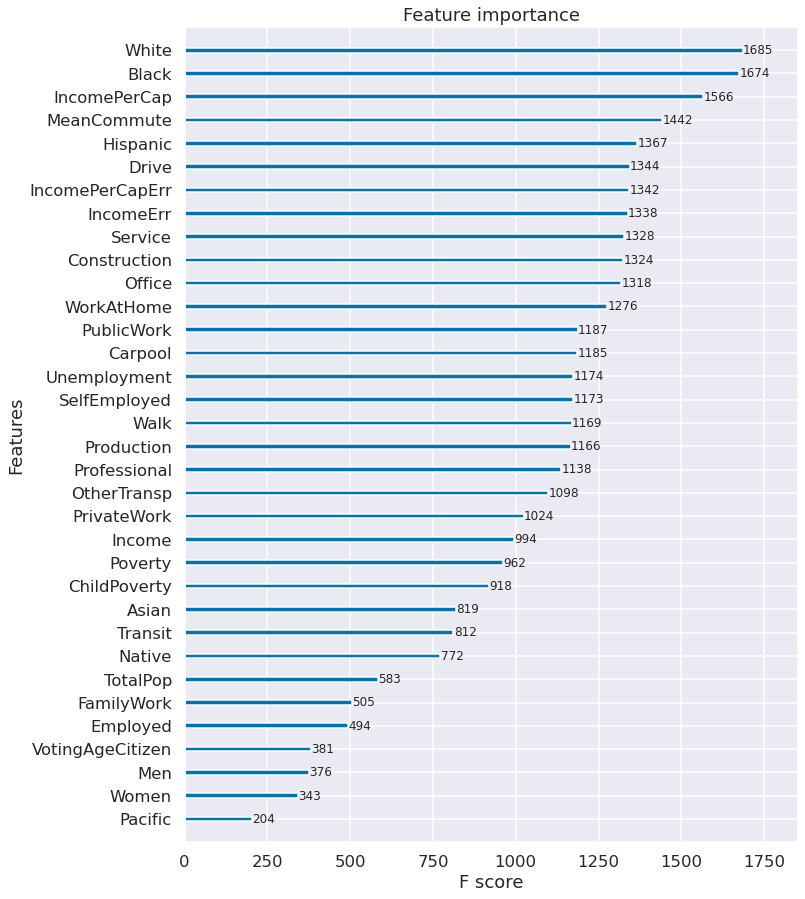

In [128]:
xgb.plot_importance(Model_XGB_fit)
plt.rcParams['figure.figsize'] = [11, 15]
plt.show()

In [150]:
y_test

Response
state     county                    
Arizona   Apache County     0.329408
          Cochise County    0.599723
          Coconino County   0.377031
          Gila County       0.672657
          Graham County     0.727119
...                              ...
Wisconsin Waukesha County   0.605752
          Waupaca County    0.661385
          Waushara County   0.672635
          Winnebago County  0.520336
          Wood County       0.597645

[385 rows x 1 columns]

In [163]:
final = pd.DataFrame({'predict':Model_XGB_fit.predict(x_test),
                                                  'y':y_test.iloc[:,0]})

In [194]:
final

predict         y     votes
state     county                                        
Arizona   Apache County     0.365623  0.329408   34735.0
          Cochise County    0.604721  0.599723   59289.0
          Coconino County   0.423386  0.377031   71750.0
          Gila County       0.684857  0.672657   27320.0
          Graham County     0.652352  0.727119   14783.0
...                              ...       ...       ...
Wisconsin Waukesha County   0.527093  0.605752  263555.0
          Waupaca County    0.670256  0.661385   28655.0
          Waushara County   0.764723  0.672635   13404.0
          Winnebago County  0.521118  0.520336   91856.0
          Wood County       0.652303  0.597645   40673.0

[385 rows x 3 columns]

In [164]:
votes = pd.DataFrame({'votes':df[df.columns[0]]+df[df.columns[1]]})
votes

votes
state   county                     
Alabama Autauga County      27341.0
        Baldwin County     108122.0
        Barbour County      10438.0
        Bibb County          9511.0
        Blount County       27351.0
...                             ...
Wyoming Sweetwater County   16052.0
        Teton County        14189.0
        Uinta County         9087.0
        Washakie County      3896.0
        Weston County        3467.0

[4809 rows x 1 columns]

In [165]:
final = pd.merge(final, votes, left_index=True, right_index=True, how='left')
final_votes = final.copy()

In [166]:
final_votes['predict'] = final_votes['predict'] * final_votes['votes']
final_votes['y'] = final_votes['y'] * final_votes['votes']

In [167]:
final_state_votes = final_votes.reset_index().groupby('state').sum()

In [168]:
final_state_votes['predict_perc'] = final_state_votes['predict']/final_state_votes['votes']
final_state_votes['y_perc'] = final_state_votes['y']/final_state_votes['votes']

In [169]:
final_state_votes

,predict,y,votes,predict_perc,y_perc
state,,,,,
Arizona,1.502576e+06,1661686.0,3333829.0,0.450706,0.498432
Florida,4.890812e+06,5081384.0,9602581.0,0.509323,0.529169
Michigan,2.745081e+06,2484111.0,5100236.0,0.538226,0.487058
North Carolina,2.782842e+06,2587241.0,5074929.0,0.548351,0.509808
Pennsylvania,3.019238e+06,2990908.0,6223387.0,0.485144,0.480592
Wisconsin,1.657722e+06,1539897.0,3137702.0,0.528324,0.490772
